In [1]:
import tensorflow as tf
import tensorflow_compression as tfc
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

2023-06-02 17:53:55.688758: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-02 17:53:55.714695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 17:53:56.116019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [3]:
class BottleNeck(keras.Model):
    def __init__(self, input_shape=(224,224,3), num_bottleneck_channels=24, num_target_channels=256,
                 encoder_channel_sizes=None, decoder_channel_sizes=None):
        super(BottleNeck, self).__init__()
        if encoder_channel_sizes is None:
            encoder_channel_sizes = \
                [input_shape[2], num_bottleneck_channels * 4, num_bottleneck_channels * 2, num_bottleneck_channels]

        if decoder_channel_sizes is None:
            decoder_channel_sizes = \
                [encoder_channel_sizes[-1], num_target_channels * 2, num_target_channels, num_target_channels]
        self.encoder = tf.keras.Sequential ([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv2D(filters=encoder_channel_sizes[1],
                          kernel_size=5, strides=2, padding='same', use_bias=False),
            tfc.layers.GDN(),
            layers.Conv2D(filters=encoder_channel_sizes[2],
                          kernel_size=5, strides=2, padding='same', use_bias=False),
            tfc.layers.GDN(),
            layers.Conv2D(filters=encoder_channel_sizes[3],
                          kernel_size=2, strides=1, padding='same', use_bias=False)
        ])
        self.decoder = tf.keras.Sequential ([
            layers.Conv2D(input_shape=(7,7,24),filters=decoder_channel_sizes[1],
                          kernel_size=2, strides=1, padding='same', use_bias=False),
            tfc.layers.GDN(inverse=True),
            layers.Conv2D(filters=decoder_channel_sizes[2],
                          kernel_size=2, strides=1, padding='same', use_bias=False),
            tfc.layers.GDN(inverse=True),
            layers.Conv2D(filters=decoder_channel_sizes[3],
                          kernel_size=2, strides=1, padding='same', use_bias=False),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
input_shape = (28, 28, 1)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

2023-06-02 17:53:57.153090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-02 17:53:57.169205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-02 17:53:57.169334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
teacher = keras.models.load_model('models/resnet50-tf.h5')

In [6]:
bottle_neck = BottleNeck(input_shape=(28,28,1))
truncated_teacher = keras.Model(inputs = teacher.layers[19].input, outputs = teacher.layers[-1].output)
truncated_teacher.trainable = False
student = keras.models.Sequential([
    bottle_neck,
    truncated_teacher
])

In [7]:
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=["accuracy"],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(x_train, y_train, epochs=20)

Epoch 1/20


/home/ezraf/miniconda3/envs/tf/lib/python3.11/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-06-02 17:54:03.659851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-02 17:54:04.183344: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-02 17:54:04.945855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-02 17:54:05.469441: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4ef73b9500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-02 17:54:05.469464: I tensorflow/compiler/xla/ser

1875/1875 [==============================] - 33s 14ms/step - accuracy: 0.7558 - student_loss: 0.9326 - distillation_loss: 0.0194
Epoch 2/20
1875/1875 [==============================] - 27s 14ms/step - accuracy: 0.9181 - student_loss: 0.3055 - distillation_loss: 0.0070
Epoch 3/20
1875/1875 [==============================] - 27s 14ms/step - accuracy: 0.9352 - student_loss: 0.2306 - distillation_loss: 0.0053
Epoch 4/20
1875/1875 [==============================] - 27s 14ms/step - accuracy: 0.9452 - student_loss: 0.1947 - distillation_loss: 0.0044
Epoch 5/20
1875/1875 [==============================] - 27s 14ms/step - accuracy: 0.9521 - student_loss: 0.1719 - distillation_loss: 0.0039
Epoch 6/20
1875/1875 [==============================] - 27s 14ms/step - accuracy: 0.9572 - student_loss: 0.1548 - distillation_loss: 0.0035
Epoch 7/20
1875/1875 [==============================] - 27s 14ms/step - accuracy: 0.9609 - student_loss: 0.1418 - distillation_loss: 0.0032
Epoch 8/20
1875/1875 [=========

In [8]:
distiller.evaluate(x_test, y_test)

313/313 [==============================] - 3s 6ms/step - accuracy: 0.9709 - student_loss: 0.0963


[0.9708999991416931, 0.009923894889652729]

In [9]:
distiller.student.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bottle_neck (BottleNeck)    (None, 7, 7, 256)         1297904   
                                                                 
 model (Functional)          (None, 10)                23521546  
                                                                 
Total params: 24,819,450
Trainable params: 1,297,904
Non-trainable params: 23,521,546
_________________________________________________________________


313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.98      0.96      0.97       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



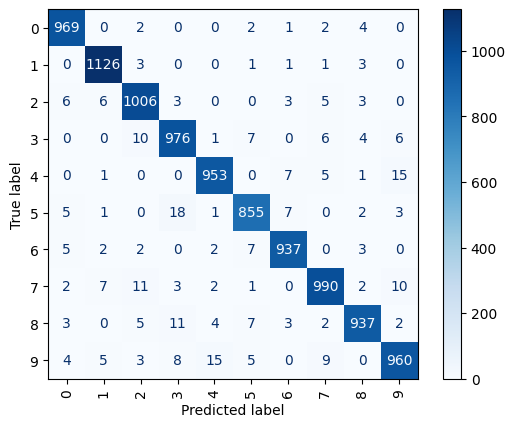

In [10]:
Y_pred = distiller.student.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)

print(classification_report(y_pred=Y_pred_classes, y_true=Y_true))
cm = confusion_matrix(Y_true, Y_pred_classes)
ConfusionMatrixDisplay(cm).plot(cmap='Blues', xticks_rotation='vertical', values_format='d')

In [11]:
distiller.student.get_layer('bottle_neck').encoder.save('models/resnet50-encoder.h5')

In [12]:
tail = student = keras.models.Sequential([
    distiller.student.get_layer('bottle_neck').decoder,
    distiller.student.get_layer('model')
])
tail.save('models/resnet50-tail.h5')